In [5]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle
from multiprocessing import Pool, Manager
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline

In [6]:
class User():
    def __init__(self, uid, year, e, km, b, a, days):
        self.years = {}
        self.tiles = {}
        self.years[year] = (e,km,b,a,days)
    
    def add_tile_year(self, year, q, e, km, b, a, days):
        self.tiles[q] = {}
        self.tiles[q][year] = (e,km,b,a,days)
    
    def coalesce(self, other_self):
        for year, data in other_self.years.items():
            self.years[year] = data
        
        for q in other_self.tiles.keys():
            if q in self.tiles:
                for year, data in other_self.tiles[q].items():
                    self.tiles[q][year] = data
            else:
                self.tiles[q] = other_self.tiles[q]

# When is a user _Experienced_?
This is a difficult question in that we cannot simply take above the mean / below the mean because of the problematic distributions within the database.

We can look at users who map more buildings than roads? We can look at users with more than half of their edits to buildings? That's a tough question.

## Who's Mapping Roads and/or Buildings on these tiles (Roles)

Port Au Prince, Haiti
132.0
440 532.46172
440 1203
West Bucharest, Romania
290.0
600 843.1990000000001
600 5197
Washington DC
155.0
422 679.4562000000001
422 3132
Adelaide, Australia
126.0
250 532.05962
250 7973


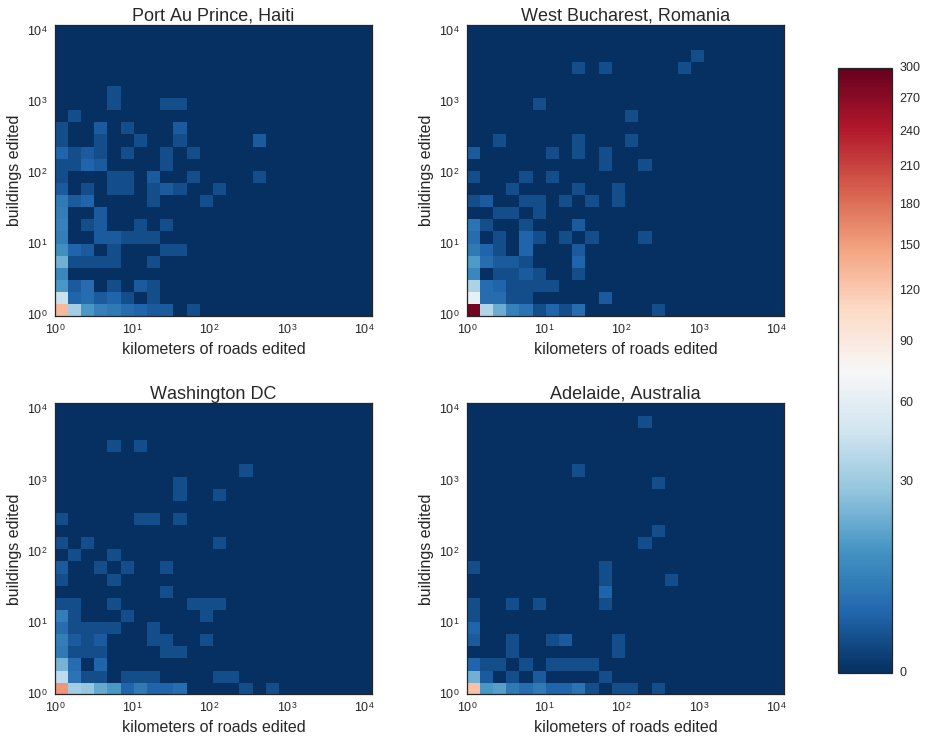

In [28]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, ax in enumerate(axs.ravel()):
    tile_data = tiles[idx]['data']
    
    kms = [];
    bs  = [];
    
    for uid, user in tile_data.items():
        u_km = 1
        u_bs = 1
        for year, tile in user.tiles[tiles[idx]['quad']].items():
            u_km += tile[1]
            u_bs += tile[2]
        kms.append(u_km)
        bs.append(u_bs)
        
    H, xedges, yedges = np.histogram2d(kms, bs, bins=np.logspace(base=10,start=0,stop=4.1,num=25))
    H = np.rot90(H)
    H = np.flipud(H)
   
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_ylim([1,np.power(10,4.1)])
    ax.set_xlim([1,np.power(10,4.1)])
    
    print(tiles[idx]['name'])
    print(max(H.flatten()))
    print(len(kms), max(kms))
    print(len(bs), max(bs))
        
    ax.set_title("%s"%(tiles[idx]['name']), fontsize=18)
    ax.set_xlabel('kilometers of roads edited', fontsize=16)
    ax.set_ylabel('buildings edited', fontsize=16)
    p = ax.pcolormesh(xedges,yedges,H, norm = matplotlib.colors.PowerNorm(gamma=0.5),
                      cmap='RdBu_r', vmin=0, vmax=300)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)

Port Au Prince, Haiti
72.0
141 472.956
141 369
West Bucharest, Romania
268.0
350 25.8858809
350 49
Washington DC
123.0
171 17.70186
171 110
Adelaide, Australia
71.0
89 77.24054
89 1409


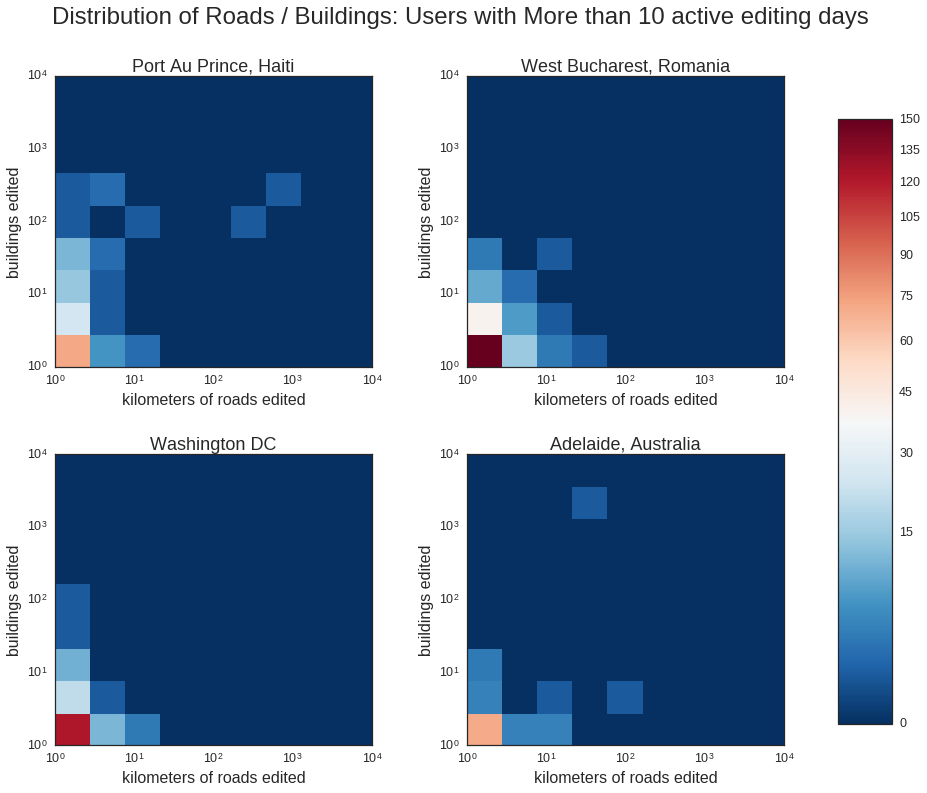

In [35]:
threshold = 10
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, ax in enumerate(axs.ravel()):
    tile_data = tiles[idx]['data']
    
    kms = [];
    bs  = [];
    
    for uid, user in tile_data.items():
        
        if total_active_days(user) > threshold:
            continue
        
        u_km = 1
        u_bs = 1
        for year, tile in user.tiles[tiles[idx]['quad']].items():
            u_km += tile[1]
            u_bs += tile[2]
        kms.append(u_km)
        bs.append(u_bs)
        
    H, xedges, yedges = np.histogram2d(kms, bs, bins=np.logspace(base=10,start=0,stop=4,num=10))
    H = np.rot90(H)
    H = np.flipud(H)
   
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    print(tiles[idx]['name'])
    print(max(H.flatten()))
    print(len(kms), max(kms))
    print(len(bs), max(bs))
        
    ax.set_title("%s"%(tiles[idx]['name']), fontsize=18)
    ax.set_xlabel('kilometers of roads edited', fontsize=16)
    ax.set_ylabel('buildings edited', fontsize=16)
    p = ax.pcolormesh(xedges,yedges,H, norm = matplotlib.colors.PowerNorm(gamma=0.5),
                      cmap='RdBu_r', vmin=0, vmax=150)

plt.suptitle("Distribution of Roads / Buildings: Users with More than %s active editing days"%(threshold), fontsize=24)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(p, cax=cbar_ax)

# Experienced vs. Inexperienced Objects on each tile

In [37]:
def type_counts(user):
    kms = 0;
    bs  = 0;
    a   = 0;
    e   = 0;
    for year, d in user.years.items():
        e   += d[0]
        kms += d[1]
        bs  += d[2]
        a   += d[3]
    return (e, kms, bs, a)

Port Au Prince, Haiti
2914.2134389599987 14872
West Bucharest, Romania
3985.7433897900005 20069
Washington DC
3455.9825681299967 12093
Adelaide, Australia
3154.8619157 11112


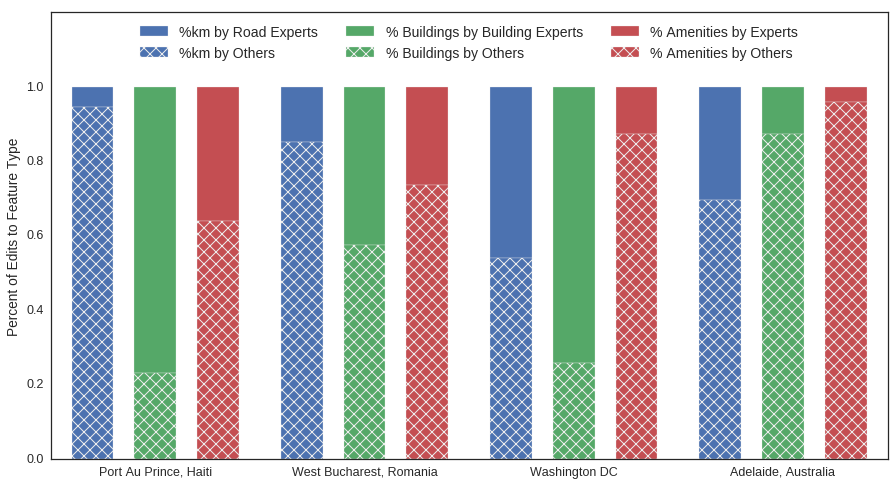

In [66]:
km_threshold = 100
b_threshold  = 100
a_threshold  = 100

sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
plt.figure().set_size_inches(15,8)
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax = plt.gca()

prop_iter = iter(plt.rcParams['axes.prop_cycle'])

color1 = next(prop_iter)['color']
color2 = next(prop_iter)['color']
color3 = next(prop_iter)['color']

for idx, study_tile in enumerate(tiles):
    print(study_tile['name'])
    total_kms       = 0;
    total_buildings = 0;
    total_amenities = 0;
    
    exp_kms         = 0;
    exp_buildings   = 0;
    exp_amenities   = 0;

    for uid, user in study_tile['data'].items():

        e, km, b, a = type_counts(user)
        
        u_km = 0
        u_b  = 0
        u_a  = 0

        for year, tile in user.tiles[study_tile['quad']].items():
            u_km += tile[1]
            u_b  += tile[2]
            u_a  += tile[3]

        if u_km > km_threshold and u_b < b_threshold:
            exp_kms += u_km
        total_kms += u_km

        if u_b > b_threshold and u_km < km_threshold:
            exp_buildings += u_b
        total_buildings += u_b

        if u_a > a_threshold and u_km < km_threshold:
            exp_amenities += u_a
        total_amenities += u_a
        
    #Let's do these as percentages instead?
    noob_kms = (total_kms-exp_kms)/total_kms
    exp_kms  = exp_kms/total_kms
            
    p = plt.bar(idx, exp_kms, bottom=noob_kms, width=0.2, color=color1)
    m = plt.bar(idx, noob_kms, 0.2, hatch="XX", color=color1)

    
    if idx==3:
        p.set_label("%km by Road Experts")
        m.set_label("%km by Others")

    noob_buildings = (total_buildings-exp_buildings)/total_buildings
    exp_buildings  = exp_buildings/total_buildings
    
    p2 = plt.bar(idx+0.3, exp_buildings, 0.2, bottom=noob_buildings, color=color2)
    m2 = plt.bar(idx+0.3, noob_buildings, 0.2, hatch="XX", color=color2)
    
    if idx==3:
        p2.set_label("% Buildings by Building Experts")
        m2.set_label("% Buildings by Others")
        
    noob_amenities = (total_amenities-exp_amenities)/total_amenities
    exp_amenities  = exp_amenities/total_amenities

    p2 = plt.bar(idx+0.6, exp_amenities, 0.2, bottom=noob_amenities, color=color3)
    m2 = plt.bar(idx+0.6, noob_amenities, 0.2, hatch="XX", color=color3)    

    if idx==3:
        p2.set_label("% Amenities by Experts")
        m2.set_label("% Amenities by Others")


    
    print(total_kms, total_buildings)
ax.set_xticks([0.4, 1.4, 2.4, 3.4])
ax.set_xticklabels([t['name'] for t in tiles])
ax.set_xlim([-0.1,3.9])
ax.set_ylabel("Percent of Edits to Feature Type")
ax.set_ylim(0,1.2)
plt.legend(loc='upper center', ncol=3, fontsize=14)
None

Port Au Prince, Haiti
2914.2134389599987 14872
West Bucharest, Romania
3985.7433897900005 20069
Washington DC
3455.9825681299967 12093
Adelaide, Australia
3154.8619157 11112


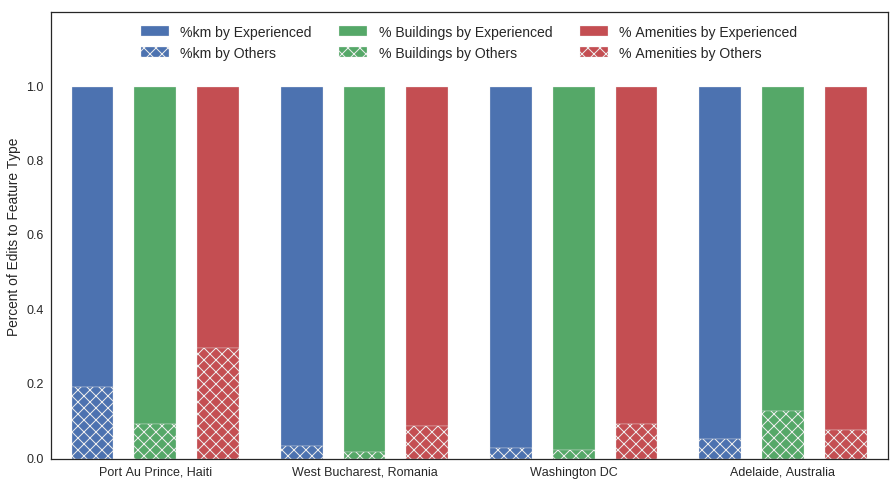

In [74]:
km_threshold = 100
b_threshold  = 100
a_threshold  = 100

sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
plt.figure().set_size_inches(15,8)
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax = plt.gca()

prop_iter = iter(plt.rcParams['axes.prop_cycle'])

color1 = next(prop_iter)['color']
color2 = next(prop_iter)['color']
color3 = next(prop_iter)['color']

for idx, study_tile in enumerate(tiles):
    print(study_tile['name'])
    total_kms       = 0;
    total_buildings = 0;
    total_amenities = 0;
    
    exp_kms         = 0;
    exp_buildings   = 0;
    exp_amenities   = 0;

    for uid, user in study_tile['data'].items():

        e, km, b, a = type_counts(user)
        
        u_km = 0
        u_b  = 0
        u_a  = 0

        for year, tile in user.tiles[study_tile['quad']].items():
            u_km += tile[1]
            u_b  += tile[2]
            u_a  += tile[3]
            
        if total_active_days(user) > 7:
            exp_kms += u_km
        total_kms += u_km

        if total_active_days(user) > 7:
            exp_buildings += u_b
        total_buildings += u_b

        if total_active_days(user) > 7:
            exp_amenities += u_a
        total_amenities += u_a
        
    #Let's do these as percentages instead?
    noob_kms = (total_kms-exp_kms)/total_kms
    exp_kms  = exp_kms/total_kms
            
    p = plt.bar(idx, exp_kms, bottom=noob_kms, width=0.2, color=color1)
    m = plt.bar(idx, noob_kms, 0.2, hatch="XX", color=color1)

    
    if idx==3:
        p.set_label("%km by Experienced")
        m.set_label("%km by Others")

    noob_buildings = (total_buildings-exp_buildings)/total_buildings
    exp_buildings  = exp_buildings/total_buildings
    
    p2 = plt.bar(idx+0.3, exp_buildings, 0.2, bottom=noob_buildings, color=color2)
    m2 = plt.bar(idx+0.3, noob_buildings, 0.2, hatch="XX", color=color2)
    
    if idx==3:
        p2.set_label("% Buildings by Experienced")
        m2.set_label("% Buildings by Others")
        
    noob_amenities = (total_amenities-exp_amenities)/total_amenities
    exp_amenities  = exp_amenities/total_amenities

    p2 = plt.bar(idx+0.6, exp_amenities, 0.2, bottom=noob_amenities, color=color3)
    m2 = plt.bar(idx+0.6, noob_amenities, 0.2, hatch="XX", color=color3)    

    if idx==3:
        p2.set_label("% Amenities by Experienced")
        m2.set_label("% Amenities by Others")


    
    print(total_kms, total_buildings)
ax.set_xticks([0.4, 1.4, 2.4, 3.4])
ax.set_xticklabels([t['name'] for t in tiles])
ax.set_xlim([-0.1,3.9])
ax.set_ylabel("Percent of Edits to Feature Type")
ax.set_ylim(0,1.2)
plt.legend(loc='upper center', ncol=3, fontsize=14)
None

In [6]:
def customYFormatter(x,p):
    if x > 10000 and x < 1000000:
        return "{0:.2f}".format(x/1000)+"K"
    elif x >= 1000000 and x < 1000000000:
        return "{0:.2f}".format(x/1000000)+"M"
    elif x >= 1000000000:
        return "{0:.2f}".format(x/1000000000)+"B"
    else:
        return str(int(x))

def log10Formatter(x,p):
    x = np.pow(10,x)
    return customYFormatter(x,p)

def log1pFormatter(x,p):
    x = np.exp(x) - 1 
    return customYFormatter(x,p)

In [67]:
def total_active_days(user):
    days = 0
    for year, d in user.years.items():
        days += d[4]
    return days